In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import pickle

In [2]:
DATASET_PATH = "../../../Dataset/Collected Dataset/"

flow_files = {
    "attack": [
        "icmp_ddos_flood.csv",
        "land_attack.csv",
        "malformed_packets.csv",
        "nestea_attack.csv",
        "nmap_probe_attack.csv",
        "ping_of_death_attack.csv",
        "tcp_ddos_flood.csv",
        "udp_ddos_flood.csv"
    ],
    "normal": [
        "normal_iperf.csv",
        "normal_w3m.csv"
    ]
}

In [3]:
dfs = []

for attack_type, files in flow_files.items():
    for file in files:
        try:
            data = pd.read_csv(DATASET_PATH + file)
            data["type"] = attack_type
            dfs.append(data)
        except FileNotFoundError:
            print("Error: File "+ file + " not found. Skipping...")

# Concatenate all DataFrames
combined = pd.concat(dfs, ignore_index=True)
print("Successfully combined data into a single DataFrame!")

Successfully combined data into a single DataFrame!


In [4]:
# Extracting relevant features
combined['ip_bytes_sec'] = combined['ip_bytes'] / combined['ip_duration']
combined['ip_packets_sec'] = combined['ip_packet'] / combined['ip_duration']
combined['ip_bytes_packet'] = combined['ip_bytes'] / combined['ip_packet']
combined['port_bytes_sec'] = combined['port_bytes'] / combined['ip_duration']
combined['port_packet_sec'] = combined['port_packet'] / combined['ip_duration']
combined['port_byte_packet'] = combined['port_bytes'] / combined['port_packet']
combined['port_flow_count_sec'] = combined['port_flow_count'] / combined['ip_duration']
combined['table_matched_lookup'] = combined['table_matched_count'] / combined['table_lookup_count']
combined['table_active_lookup'] = combined['table_active_count'] / combined['table_lookup_count']
combined['port_rx_packets_sec'] = combined['port_rx_packets'] / combined['port_duration_sec']
combined['port_tx_packets_sec'] = combined['port_tx_packets'] / combined['port_duration_sec']
combined['port_rx_bytes_sec'] = combined['port_rx_bytes'] / combined['port_duration_sec']
combined['port_tx_bytes_sec'] = combined['port_tx_bytes'] / combined['port_duration_sec']

In [5]:
# Removing identifying features
features = combined[
    [
        'ip_bytes_sec',
        'ip_packets_sec',
        'ip_bytes_packet',
        'port_bytes_sec',
        'port_packet_sec',
        'port_byte_packet',
        'port_flow_count_sec',
        'table_matched_lookup',
        'table_active_lookup',
        'port_rx_packets_sec',
        'port_tx_packets_sec',
        'port_rx_bytes_sec',
        'port_tx_bytes_sec',
        'type'
    ]
].copy()
features.describe()

C:\Users\CSE\AppData\Roaming\Python\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\CSE\AppData\Roaming\Python\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\CSE\AppData\Roaming\Python\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\CSE\AppData\Roaming\Python\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\CSE\AppData\Roaming\Python\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


ip_bytes_sec  ip_packets_sec  ip_bytes_packet  port_bytes_sec  \
count  5.053000e+04    5.053000e+04     49849.000000    5.057300e+04   
mean            inf             inf       494.915613             inf   
std             NaN             NaN       944.887709             NaN   
min    0.000000e+00    0.000000e+00        42.000000    1.814542e+01   
25%    6.125000e+00    1.150877e-01        42.000000    1.402297e+04   
50%    9.973598e+02    1.187286e+01        54.000000    9.327414e+04   
75%    6.754816e+04    3.140652e+02       154.194175    4.107108e+05   
max             inf             inf      6221.172685             inf   

       port_packet_sec  port_byte_packet  port_flow_count_sec  \
count     5.057300e+04      50573.000000         5.057300e+04   
mean               inf        539.605586                  inf   
std                NaN        668.153399                  NaN   
min       2.145422e-01         42.003799         2.153625e-03   
25%       1.016242e+02         46.575499         1.624130e-02   
50%       5.600522e+02         55.617732         2.508961e-02   
75%       1.437216e+03       1065.198882         4.895105e-02   
max                inf       3174.864845                  inf   

       table_matched_lookup  table_active_lookup  port_rx_packets_sec  \
count          50573.000000         50573.000000         50573.000000   
mean               0.999999             0.000615           334.377167   
std                0.000079             0.003125           628.565251   
min                0.987500             0.000003             0.047170   
25%                1.000000             0.000012             0.480519   
50%                1.000000             0.000043            37.783163   
75%                1.000000             0.000284           294.468368   
max                1.000000             0.093333          3050.359127   

       port_tx_packets_sec  port_rx_bytes_sec  port_tx_bytes_sec  
count         50573.000000       5.057300e+04       5.057300e+04  
mean            334.484294       1.095320e+05       1.067289e+05  
std             630.734287       2.295222e+05       2.314072e+05  
min               0.059514       2.842767e+00       6.446359e+00  
25%               0.967742       3.607407e+01       9.316327e+01  
50%              34.684932       2.146387e+03       6.597053e+03  
75%             287.739033       1.045497e+05       1.000966e+05  
max            3049.918651       1.135476e+06       1.135706e+06

In [6]:
# Removing inf and NaN values
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)
features.describe()

ip_bytes_sec  ip_packets_sec  ip_bytes_packet  port_bytes_sec  \
count  4.980000e+04    49800.000000     49800.000000    4.980000e+04   
mean   9.367181e+04      236.131310       494.886636    2.819283e+05   
std    2.351507e+05      415.716971       945.110971    4.512961e+05   
min    2.359551e-01        0.005618        42.000000    1.814542e+01   
25%    6.786446e+00        0.143802        42.000000    1.399984e+04   
50%    1.096707e+03       12.144878        54.000000    9.285399e+04   
75%    6.782540e+04      314.449498       154.183838    4.101893e+05   
max    1.607856e+06     3167.000000      6221.172685    2.818552e+07   

       port_packet_sec  port_byte_packet  port_flow_count_sec  \
count     49800.000000      49800.000000         49800.000000   
mean        907.439541        542.432774             0.066142   
std        1786.114418        670.550416             0.254826   
min           0.214542         42.003799             0.002154   
25%         101.198653         46.581597             0.016166   
50%         548.652665         55.620882             0.024735   
75%        1427.216086       1065.232359             0.046980   
max      181944.000000       3174.864845             9.000000   

       table_matched_lookup  table_active_lookup  port_rx_packets_sec  \
count          49800.000000         49800.000000         49800.000000   
mean               1.000000             0.000566           339.410090   
std                0.000003             0.002720           632.046705   
min                0.999696             0.000003             0.047170   
25%                1.000000             0.000012             0.541667   
50%                1.000000             0.000042            38.743503   
75%                1.000000             0.000273           297.171163   
max                1.000000             0.093333          3050.359127   

       port_tx_packets_sec  port_rx_bytes_sec  port_tx_bytes_sec  
count         49800.000000       4.980000e+04       4.980000e+04  
mean            335.604130       1.111855e+05       1.067977e+05  
std             634.771152       2.308873e+05       2.324713e+05  
min               0.059514       2.842767e+00       6.446359e+00  
25%               0.904255       4.356643e+01       8.499010e+01  
50%              33.900826       2.216779e+03       6.349408e+03  
75%             286.930287       1.077352e+05       9.828474e+04  
max            3049.918651       1.135476e+06       1.135706e+06

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
features['type'].value_counts()

type
attack    40356
normal     9444
Name: count, dtype: int64

In [9]:
attack = features.loc[features['type'] == 'attack']
normal = features.loc[features['type'] == 'normal']

In [10]:
attack.drop('type', axis=1, inplace=True)
normal.drop('type', axis=1, inplace=True)

C:\Users\CSE\AppData\Local\Temp\ipykernel_12268\2076348856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack.drop('type', axis=1, inplace=True)
C:\Users\CSE\AppData\Local\Temp\ipykernel_12268\2076348856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal.drop('type', axis=1, inplace=True)


In [11]:
features_list = [
        'ip_bytes_sec',
        'ip_packets_sec',
        'ip_bytes_packet',
        'port_bytes_sec',
        'port_packet_sec',
        'port_byte_packet',
        'port_flow_count_sec',
        'table_matched_lookup',
        'table_active_lookup',
        'port_rx_packets_sec',
        'port_tx_packets_sec',
        'port_rx_bytes_sec',
        'port_tx_bytes_sec',
    ]

C:\Users\CSE\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


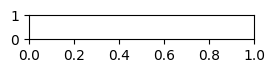

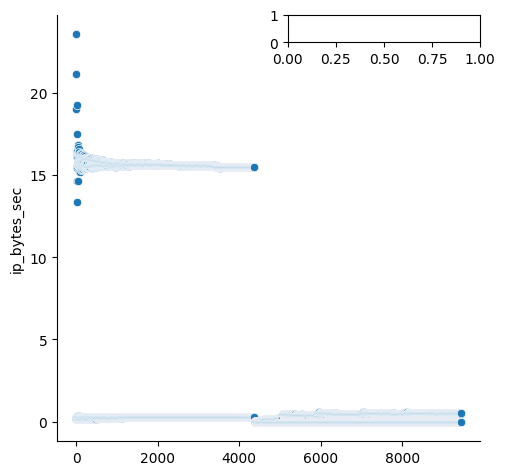

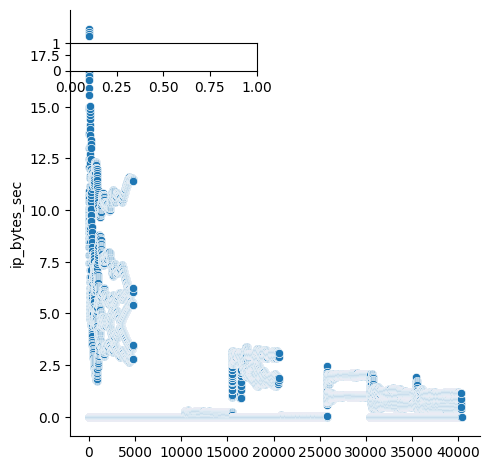

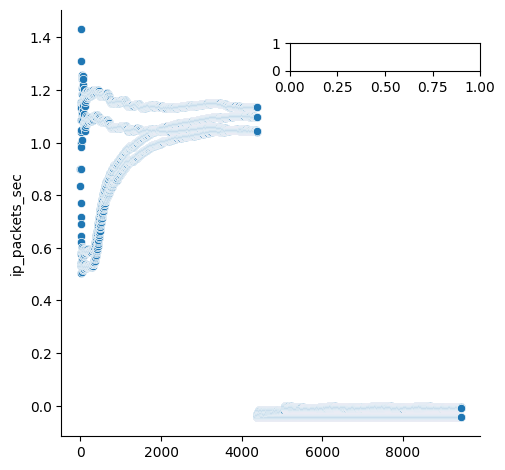

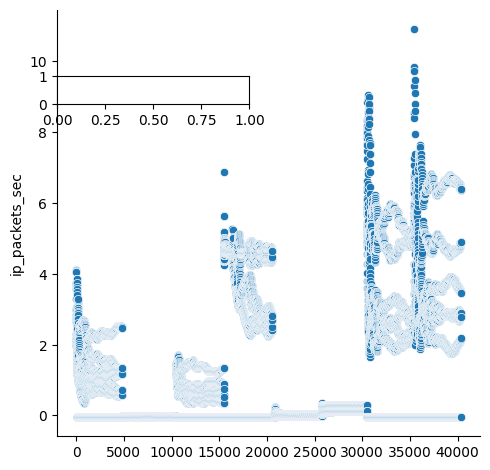

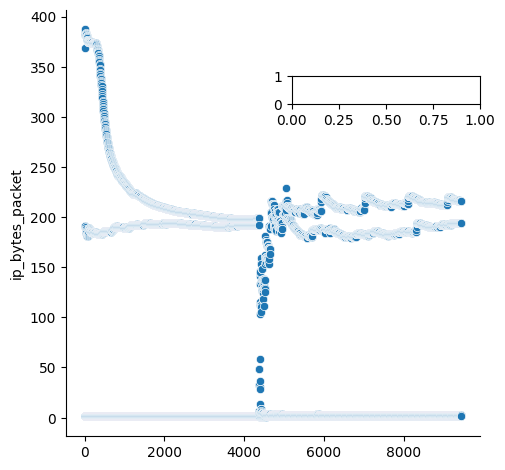

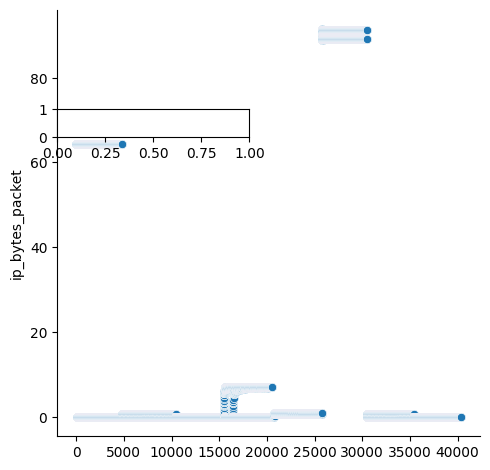

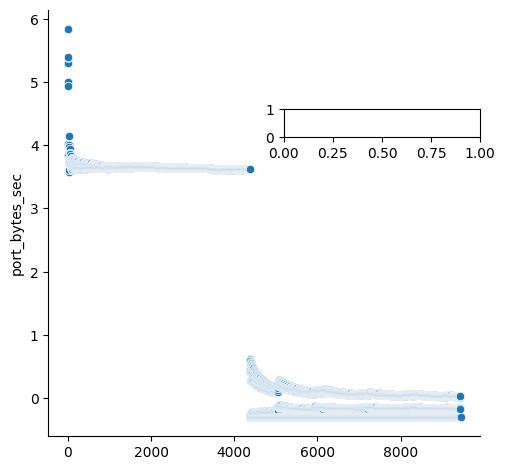

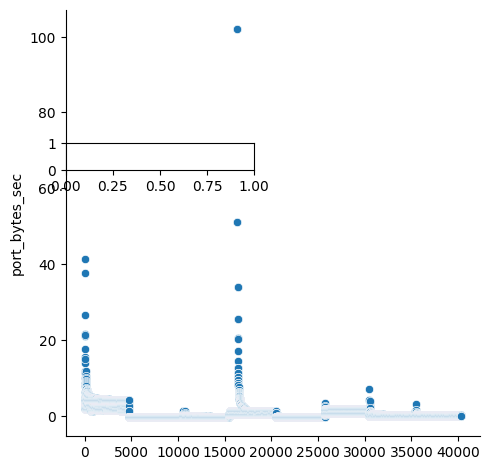

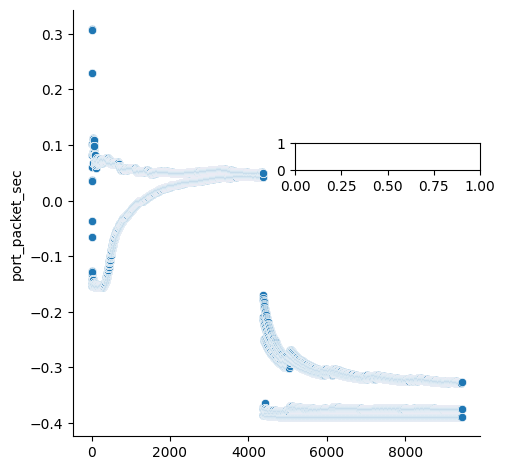

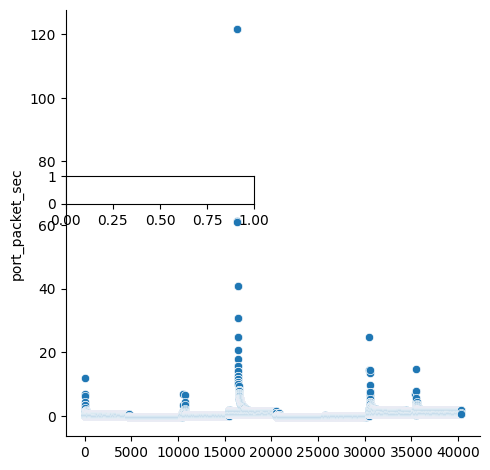

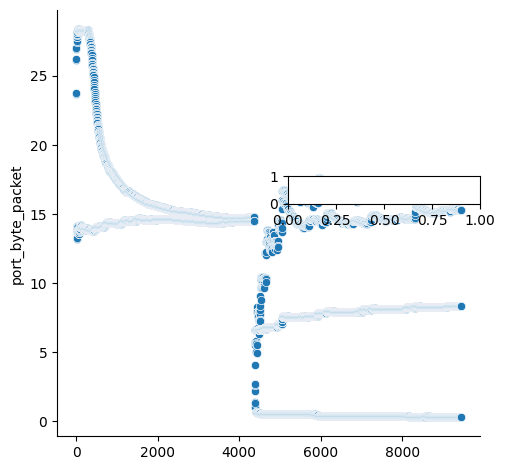

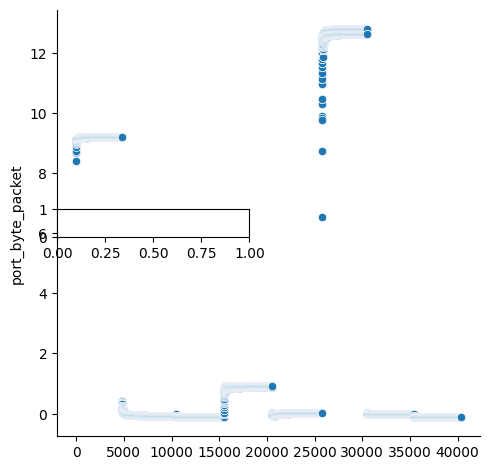

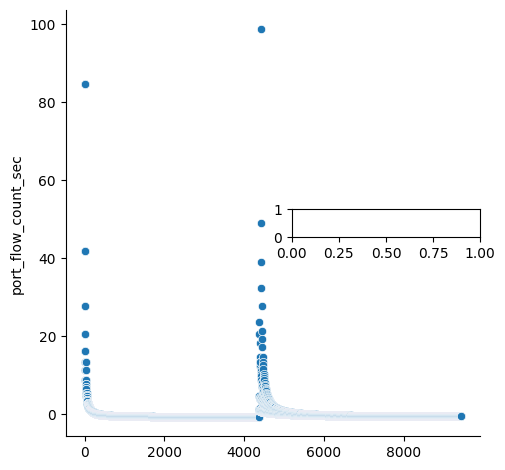

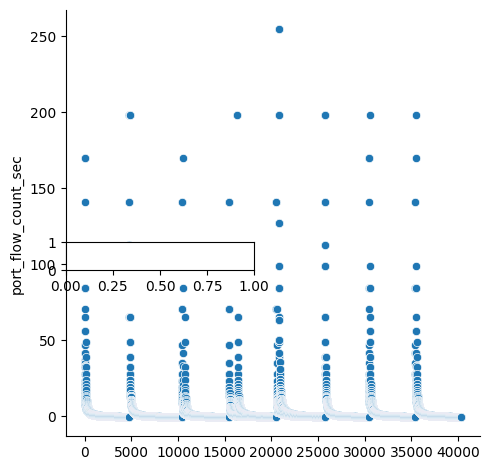

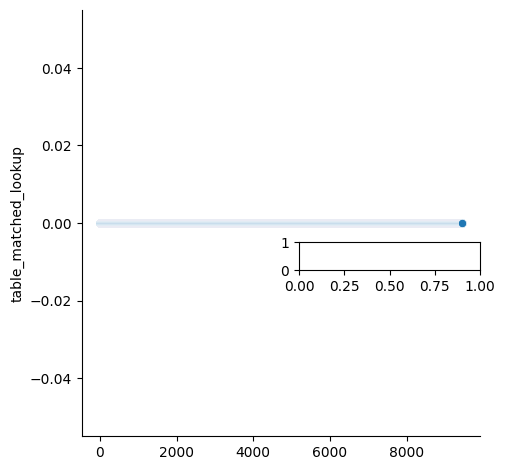

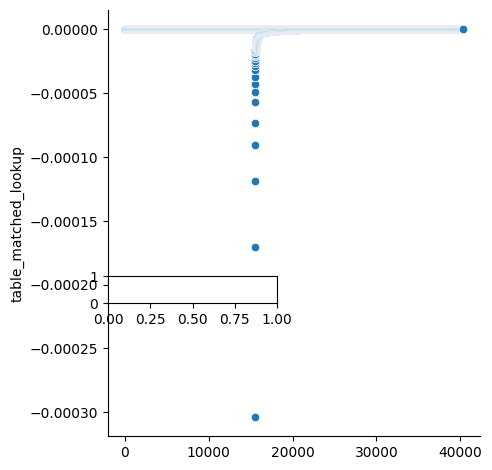

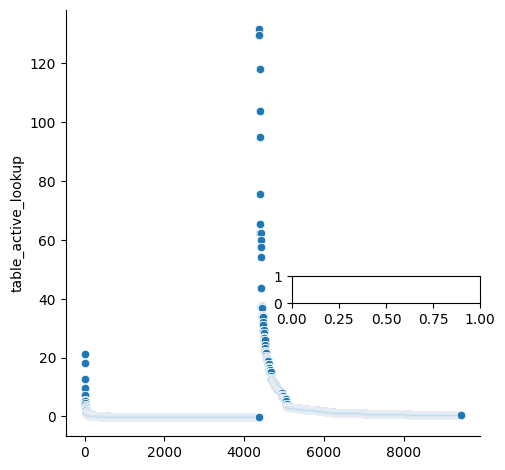

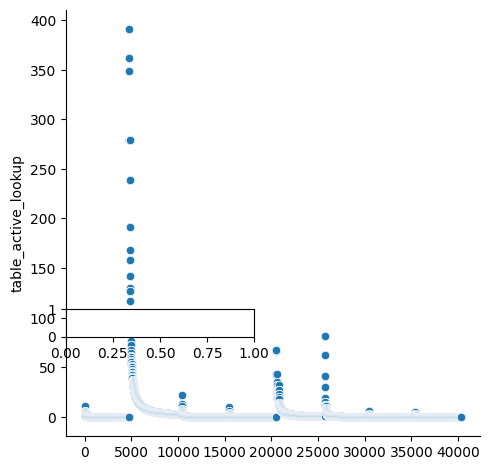

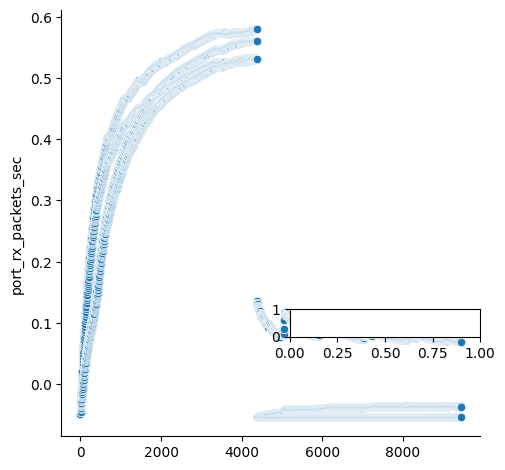

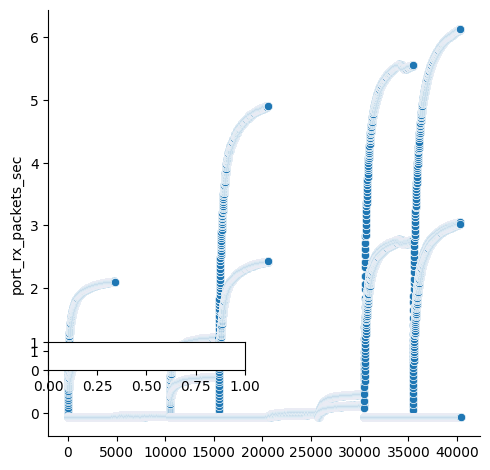

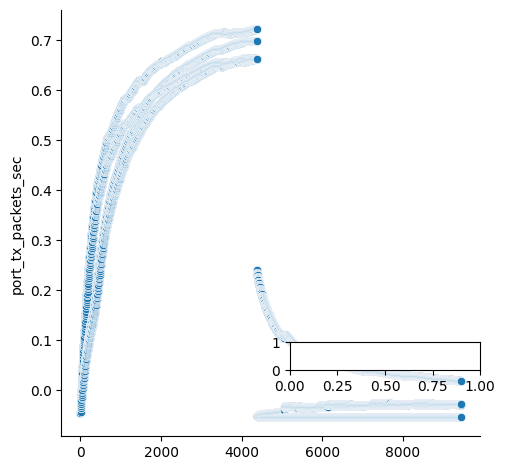

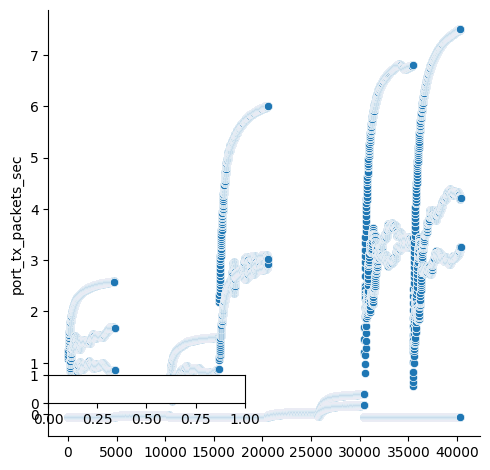

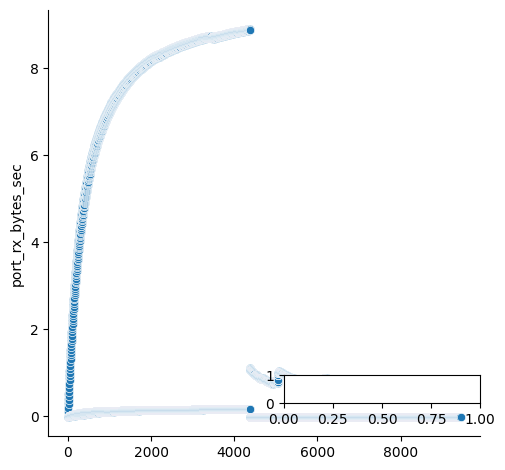

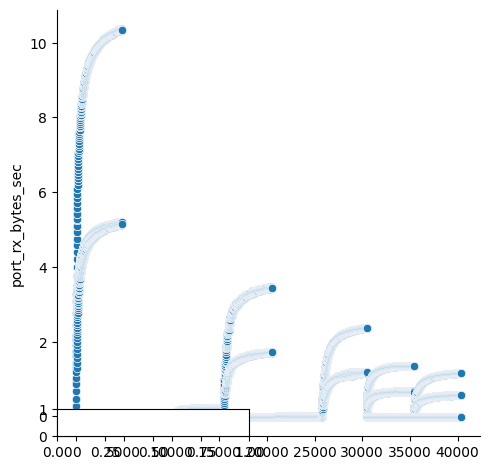

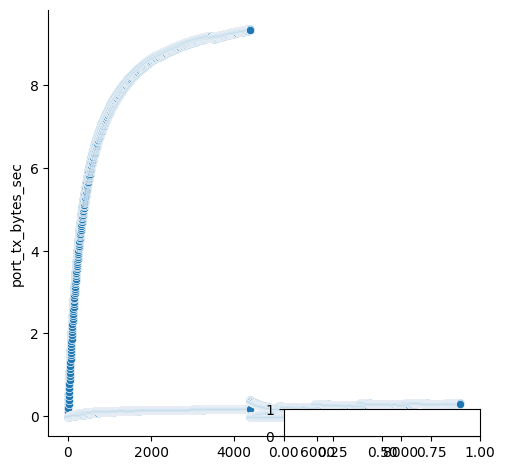

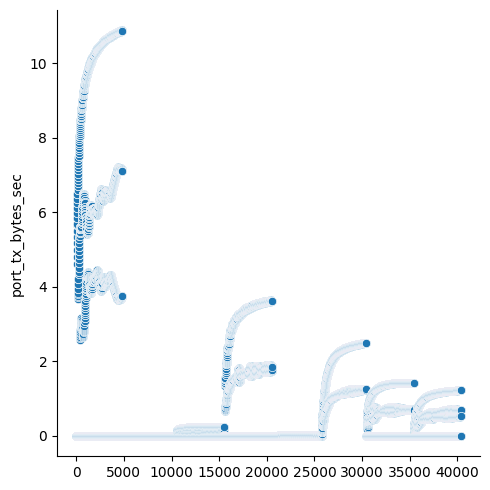

In [19]:
i = -1
for x in features_list:
    i += 1
    plt.subplot(len(features_list), 2, i + 1)
    sns.relplot(data=normal[x])
    i += 1
    plt.subplot(len(features_list), 2, i + 1)
    sns.relplot(data=attack[x])
plt.tight_layout()

In [14]:
scaler = RobustScaler()

attack = pd.DataFrame(scaler.fit_transform(attack), columns=[
    'ip_bytes_sec',
    'ip_packets_sec',
    'ip_bytes_packet',
    'port_bytes_sec',
    'port_packet_sec',
    'port_byte_packet',
    'port_flow_count_sec',
    'table_matched_lookup',
    'table_active_lookup',
    'port_rx_packets_sec',
    'port_tx_packets_sec',
    'port_rx_bytes_sec',
    'port_tx_bytes_sec',
])

normal = pd.DataFrame(scaler.transform(normal), columns=[
    'ip_bytes_sec',
    'ip_packets_sec',
    'ip_bytes_packet',
    'port_bytes_sec',
    'port_packet_sec',
    'port_byte_packet',
    'port_flow_count_sec',
    'table_matched_lookup',
    'table_active_lookup',
    'port_rx_packets_sec',
    'port_tx_packets_sec',
    'port_rx_bytes_sec',
    'port_tx_bytes_sec',
])

In [24]:
type(attack)

pandas.core.frame.DataFrame

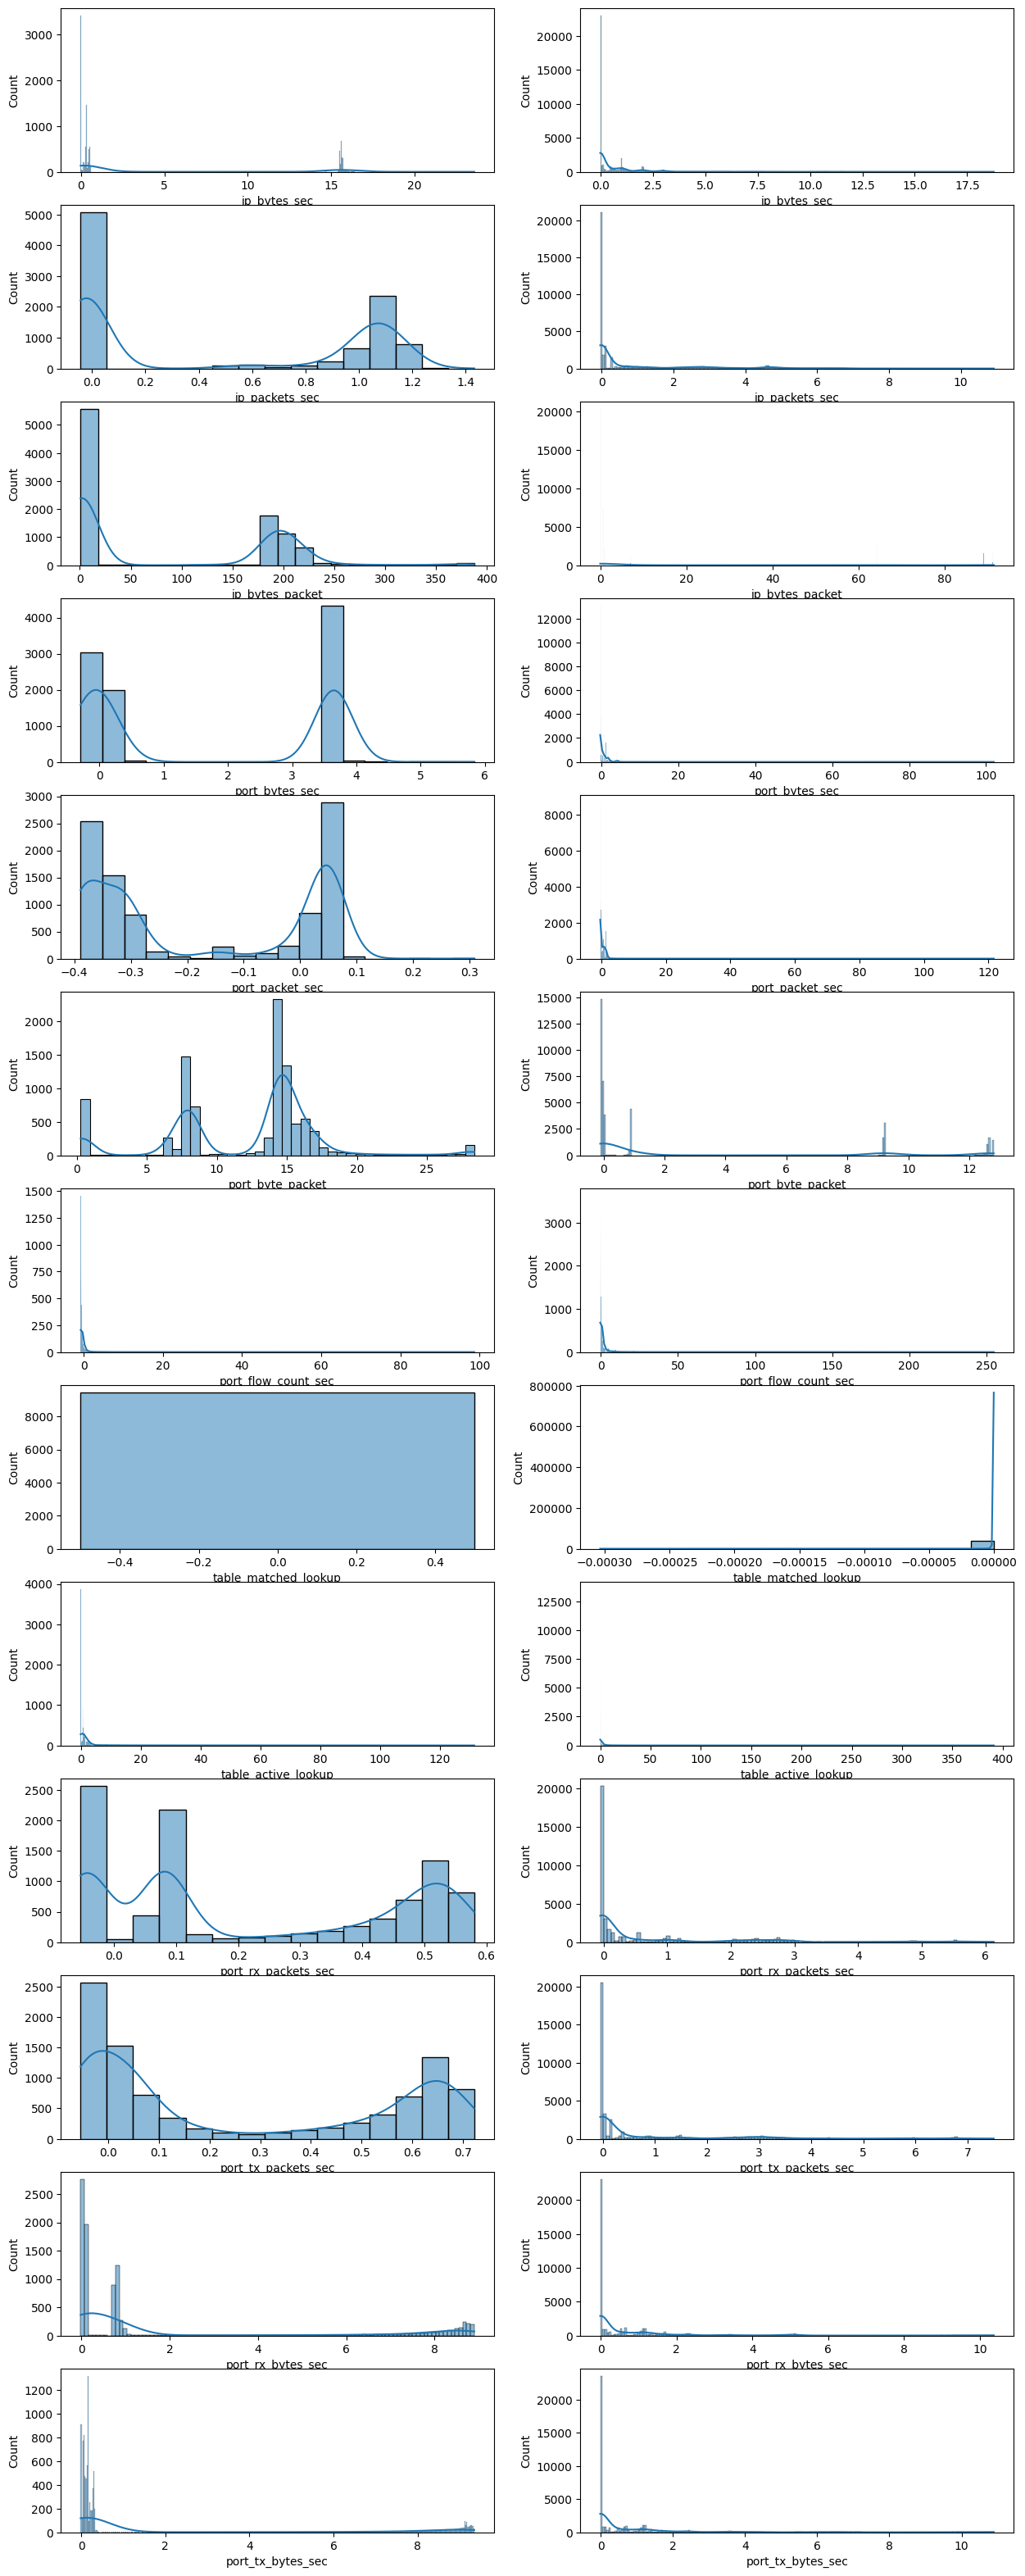

In [27]:
fig, axes = plt.subplots(len(features_list), 2, figsize=(15, 40))

i = -1
for x in features_list:
    i += 1
    sns.histplot(data=normal, x = x, ax=axes[i, 0], kde=True)
    sns.histplot(data=attack, x = x , ax=axes[i, 1], kde=True)

In [28]:
Normalfiles2 = {
    'iperf': ['normal_iperf.csv'],
    'w3m':['normal_w3m.csv']
}
df = []

In [29]:
dfs = []

for attack_type, files in flow_files.items():
    for file in files:
        try:
            data = pd.read_csv(DATASET_PATH + file)
            data["type"] = attack_type
            dfs.append(data)
        except FileNotFoundError:
            print("Error: File "+ file + " not found. Skipping...")

In [30]:
iperf = dfs[0]
w3m = dfs[1]

In [32]:
w3m.describe()

src  dst  table_id       ip_bytes    ip_packet  ip_duration  \
count  0.0  0.0    5659.0    5659.000000  5659.000000  5659.000000   
mean   NaN  NaN       0.0   31014.383813   646.137303   301.262060   
std    NaN  NaN       0.0   22430.238941   456.681153   174.422275   
min    NaN  NaN       0.0       0.000000     0.000000     0.000000   
25%    NaN  NaN       0.0   13770.000000   291.000000   150.000000   
50%    NaN  NaN       0.0   27510.000000   581.000000   301.000000   
75%    NaN  NaN       0.0   41676.000000   870.000000   452.000000   
max    NaN  NaN       0.0  106380.000000  1970.000000   604.000000   

           in_port     port_bytes  port_packet  port_flow_count  ...  \
count  5659.000000    5659.000000   5659.00000      5659.000000  ...   
mean      2.000000  215912.254815   4632.83566         6.996996  ...   
std       0.816713  129435.436449   2820.79495         0.087125  ...   
min       1.000000    8128.000000     79.00000         4.000000  ...   
25%       1.000000  108858.000000   2289.50000         7.000000  ...   
50%       2.000000  208274.000000   4473.00000         7.000000  ...   
75%       3.000000  306966.000000   6652.00000         7.000000  ...   
max       3.000000  544950.000000  11723.00000         7.000000  ...   

       port_tx_bytes  port_rx_dropped  port_tx_dropped  port_rx_errors  \
count    5659.000000           5659.0           5659.0          5659.0   
mean   124206.975967              0.0              0.0             0.0   
std     80943.890581              0.0              0.0             0.0   
min      4021.000000              0.0              0.0             0.0   
25%     60289.500000              0.0              0.0             0.0   
50%    113062.000000              0.0              0.0             0.0   
75%    165774.000000              0.0              0.0             0.0   
max    376916.000000              0.0              0.0             0.0   

       port_tx_errors  port_rx_frame_err  port_rx_over_err  port_rx_crc_err  \
count          5659.0             5659.0            5659.0           5659.0   
mean              0.0                0.0               0.0              0.0   
std               0.0                0.0               0.0              0.0   
min               0.0                0.0               0.0              0.0   
25%               0.0                0.0               0.0              0.0   
50%               0.0                0.0               0.0              0.0   
75%               0.0                0.0               0.0              0.0   
max               0.0                0.0               0.0              0.0   

       port_collisions  port_duration_sec  
count           5659.0        5659.000000  
mean               0.0         319.562113  
std                0.0         174.425723  
min                0.0          18.000000  
25%                0.0         169.000000  
50%                0.0         320.000000  
75%                0.0         471.000000  
max                0.0         622.000000  

[8 rows x 26 columns]

In [33]:
# Extracting relevant features
iperf['ip_bytes_sec'] = iperf['ip_bytes'] / iperf['ip_duration']
iperf['ip_packets_sec'] = iperf['ip_packet'] / iperf['ip_duration']
iperf['ip_bytes_packet'] = iperf['ip_bytes'] / iperf['ip_packet']
iperf['port_bytes_sec'] = iperf['port_bytes'] / iperf['ip_duration']
iperf['port_packet_sec'] = iperf['port_packet'] / iperf['ip_duration']
iperf['port_byte_packet'] = iperf['port_bytes'] / iperf['port_packet']
iperf['port_flow_count_sec'] = iperf['port_flow_count'] / iperf['ip_duration']
iperf['table_matched_lookup'] = iperf['table_matched_count'] / iperf['table_lookup_count']
iperf['table_active_lookup'] = iperf['table_active_count'] / iperf['table_lookup_count']
iperf['port_rx_packets_sec'] = iperf['port_rx_packets'] / iperf['port_duration_sec']
iperf['port_tx_packets_sec'] = iperf['port_tx_packets'] / iperf['port_duration_sec']
iperf['port_rx_bytes_sec'] = iperf['port_rx_bytes'] / iperf['port_duration_sec']
iperf['port_tx_bytes_sec'] = iperf['port_tx_bytes'] / iperf['port_duration_sec']

# Extracting relevant features
w3m['ip_bytes_sec'] = w3m['ip_bytes'] / w3m['ip_duration']
w3m['ip_packets_sec'] = w3m['ip_packet'] / w3m['ip_duration']
w3m['ip_bytes_packet'] = w3m['ip_bytes'] / w3m['ip_packet']
w3m['port_bytes_sec'] = w3m['port_bytes'] / w3m['ip_duration']
w3m['port_packet_sec'] = w3m['port_packet'] / w3m['ip_duration']
w3m['port_byte_packet'] = w3m['port_bytes'] / w3m['port_packet']
w3m['port_flow_count_sec'] = w3m['port_flow_count'] / w3m['ip_duration']
w3m['table_matched_lookup'] = w3m['table_matched_count'] / w3m['table_lookup_count']
w3m['table_active_lookup'] = w3m['table_active_count'] / w3m['table_lookup_count']
w3m['port_rx_packets_sec'] = w3m['port_rx_packets'] / w3m['port_duration_sec']
w3m['port_tx_packets_sec'] = w3m['port_tx_packets'] / w3m['port_duration_sec']
w3m['port_rx_bytes_sec'] = w3m['port_rx_bytes'] / w3m['port_duration_sec']
w3m['port_tx_bytes_sec'] = w3m['port_tx_bytes'] / w3m['port_duration_sec']

In [44]:
iperf = iperf[
    [
        'ip_bytes_sec',
        'ip_packets_sec',
        'ip_bytes_packet',
        'port_bytes_sec',
        'port_packet_sec',
        'port_byte_packet',
        'port_flow_count_sec',
        'table_matched_lookup',
        'table_active_lookup',
        'port_rx_packets_sec',
        'port_tx_packets_sec',
        'port_rx_bytes_sec',
        'port_tx_bytes_sec',
    ]
].copy()

w3m = w3m[
    [
        'ip_bytes_sec',
        'ip_packets_sec',
        'ip_bytes_packet',
        'port_bytes_sec',
        'port_packet_sec',
        'port_byte_packet',
        'port_flow_count_sec',
        'table_matched_lookup',
        'table_active_lookup',
        'port_rx_packets_sec',
        'port_tx_packets_sec',
        'port_rx_bytes_sec',
        'port_tx_bytes_sec',
    ]
].copy()

In [45]:
# Removing inf and NaN values
iperf.replace([np.inf, -np.inf], np.nan, inplace=True)
iperf.dropna(inplace=True)

# Removing inf and NaN values
w3m.replace([np.inf, -np.inf], np.nan, inplace=True)
w3m.dropna(inplace=True)

In [46]:
w3m.describe()

ip_bytes_sec  ip_packets_sec  ip_bytes_packet  port_bytes_sec  \
count   5651.000000     5651.000000      5651.000000     5651.000000   
mean     103.243002        2.151089        48.001062      791.338901   
std       39.187639        0.765994         6.000531      466.519456   
min       28.000000        0.666667        42.000000      589.643599   
25%       69.096774        1.591912        42.000000      607.007386   
50%       86.845361        1.645570        54.000000      649.284091   
75%      135.302323        3.197452        54.000000      913.258994   
max      270.000000        6.000000        54.000000    10244.000000   

       port_packet_sec  port_byte_packet  port_flow_count_sec  \
count      5651.000000       5651.000000          5651.000000   
mean         16.151799         47.950505             0.081245   
std           5.408453          4.550739             0.346948   
min          12.884083         45.732717             0.011589   
25%          13.163728         46.143911             0.015487   
50%          13.660870         46.683165             0.023179   
75%          19.537329         47.659445             0.046358   
max         127.000000         99.166667             7.000000   

       table_matched_lookup  table_active_lookup  port_rx_packets_sec  \
count                5651.0          5651.000000          5651.000000   
mean                    1.0             0.003062             5.918542   
std                     0.0             0.007061             3.053629   
min                     1.0             0.000599             0.722222   
25%                     1.0             0.000795             3.126570   
50%                     1.0             0.001184             6.054167   
75%                     1.0             0.002332             6.252220   
max                     1.0             0.093333            12.551895   

       port_tx_packets_sec  port_rx_bytes_sec  port_tx_bytes_sec  
count          5651.000000        5651.000000        5651.000000  
mean              8.108548         278.782271         388.243525  
std               2.261168         154.362219         115.994625  
min               2.222222          52.421053         221.476190  
25%               6.312197         132.887290         279.609499  
50%               6.395712         271.265252         371.652174  
75%               9.463511         299.265766         449.994695  
max              12.552674         607.065256         607.202797

In [47]:
scaler = RobustScaler()

iperf = pd.DataFrame(scaler.fit_transform(iperf), columns=[
    'ip_bytes_sec',
    'ip_packets_sec',
    'ip_bytes_packet',
    'port_bytes_sec',
    'port_packet_sec',
    'port_byte_packet',
    'port_flow_count_sec',
    'table_matched_lookup',
    'table_active_lookup',
    'port_rx_packets_sec',
    'port_tx_packets_sec',
    'port_rx_bytes_sec',
    'port_tx_bytes_sec',
])

w3m = pd.DataFrame(scaler.transform(w3m), columns=[
    'ip_bytes_sec',
    'ip_packets_sec',
    'ip_bytes_packet',
    'port_bytes_sec',
    'port_packet_sec',
    'port_byte_packet',
    'port_flow_count_sec',
    'table_matched_lookup',
    'table_active_lookup',
    'port_rx_packets_sec',
    'port_tx_packets_sec',
    'port_rx_bytes_sec',
    'port_tx_bytes_sec',
])

In [53]:
iperf.describe()

ip_bytes_sec  ip_packets_sec  ip_bytes_packet  port_bytes_sec  \
count   4794.000000    4.794000e+03      4794.000000    4.794000e+03   
mean       0.079647    7.969795e-02        -0.479975    2.525509e-01   
std        0.654538    6.545566e-01         0.499651    8.589646e-01   
min       -0.492568   -4.925868e-01        -1.000000   -5.141493e-01   
25%       -0.492566   -4.925212e-01        -1.000000   -1.977142e-01   
50%        0.000000   -3.832655e-17         0.000000   -9.846970e-17   
75%        0.507434    5.074788e-01         0.000000    8.022858e-01   
max        2.750866    2.751107e+00         0.000000    3.193550e+01   

       port_packet_sec  port_byte_packet  port_flow_count_sec  \
count     4.794000e+03       4794.000000          4794.000000   
mean      2.530214e-01         -0.546406             1.129150   
std       8.621851e-01          3.611873             6.236977   
min      -5.150009e-01       -130.254798            -0.417515   
25%      -1.978592e-01         -0.562522            -0.269734   
50%      -1.025384e-16          0.000000             0.000000   
75%       8.021408e-01          0.437478             0.730266   
max       3.207465e+01          0.832116           173.228365   

       table_matched_lookup  table_active_lookup  port_rx_packets_sec  \
count                4794.0          4794.000000         4.794000e+03   
mean                    0.0             0.789438        -7.305908e-03   
std                     0.0             3.278639         7.003426e-01   
min                     0.0            -0.424967        -6.443353e-01   
25%                     0.0            -0.278569        -6.442148e-01   
50%                     0.0             0.000000        -5.421011e-17   
75%                     0.0             0.721431         3.557852e-01   
max                     0.0            96.790942         1.383231e+00   

       port_tx_packets_sec  port_rx_bytes_sec  port_tx_bytes_sec  
count          4794.000000       4.794000e+03        4794.000000  
mean              0.517108      -6.405001e-03           0.518514  
std               0.609034       7.002594e-01           0.609367  
min              -0.001757      -6.431575e-01          -0.000181  
25%              -0.001479      -6.431490e-01          -0.000154  
50%               0.000000       5.204170e-17           0.000000  
75%               0.998521       3.568510e-01           0.999846  
max               1.706549       1.384021e+00           1.708809

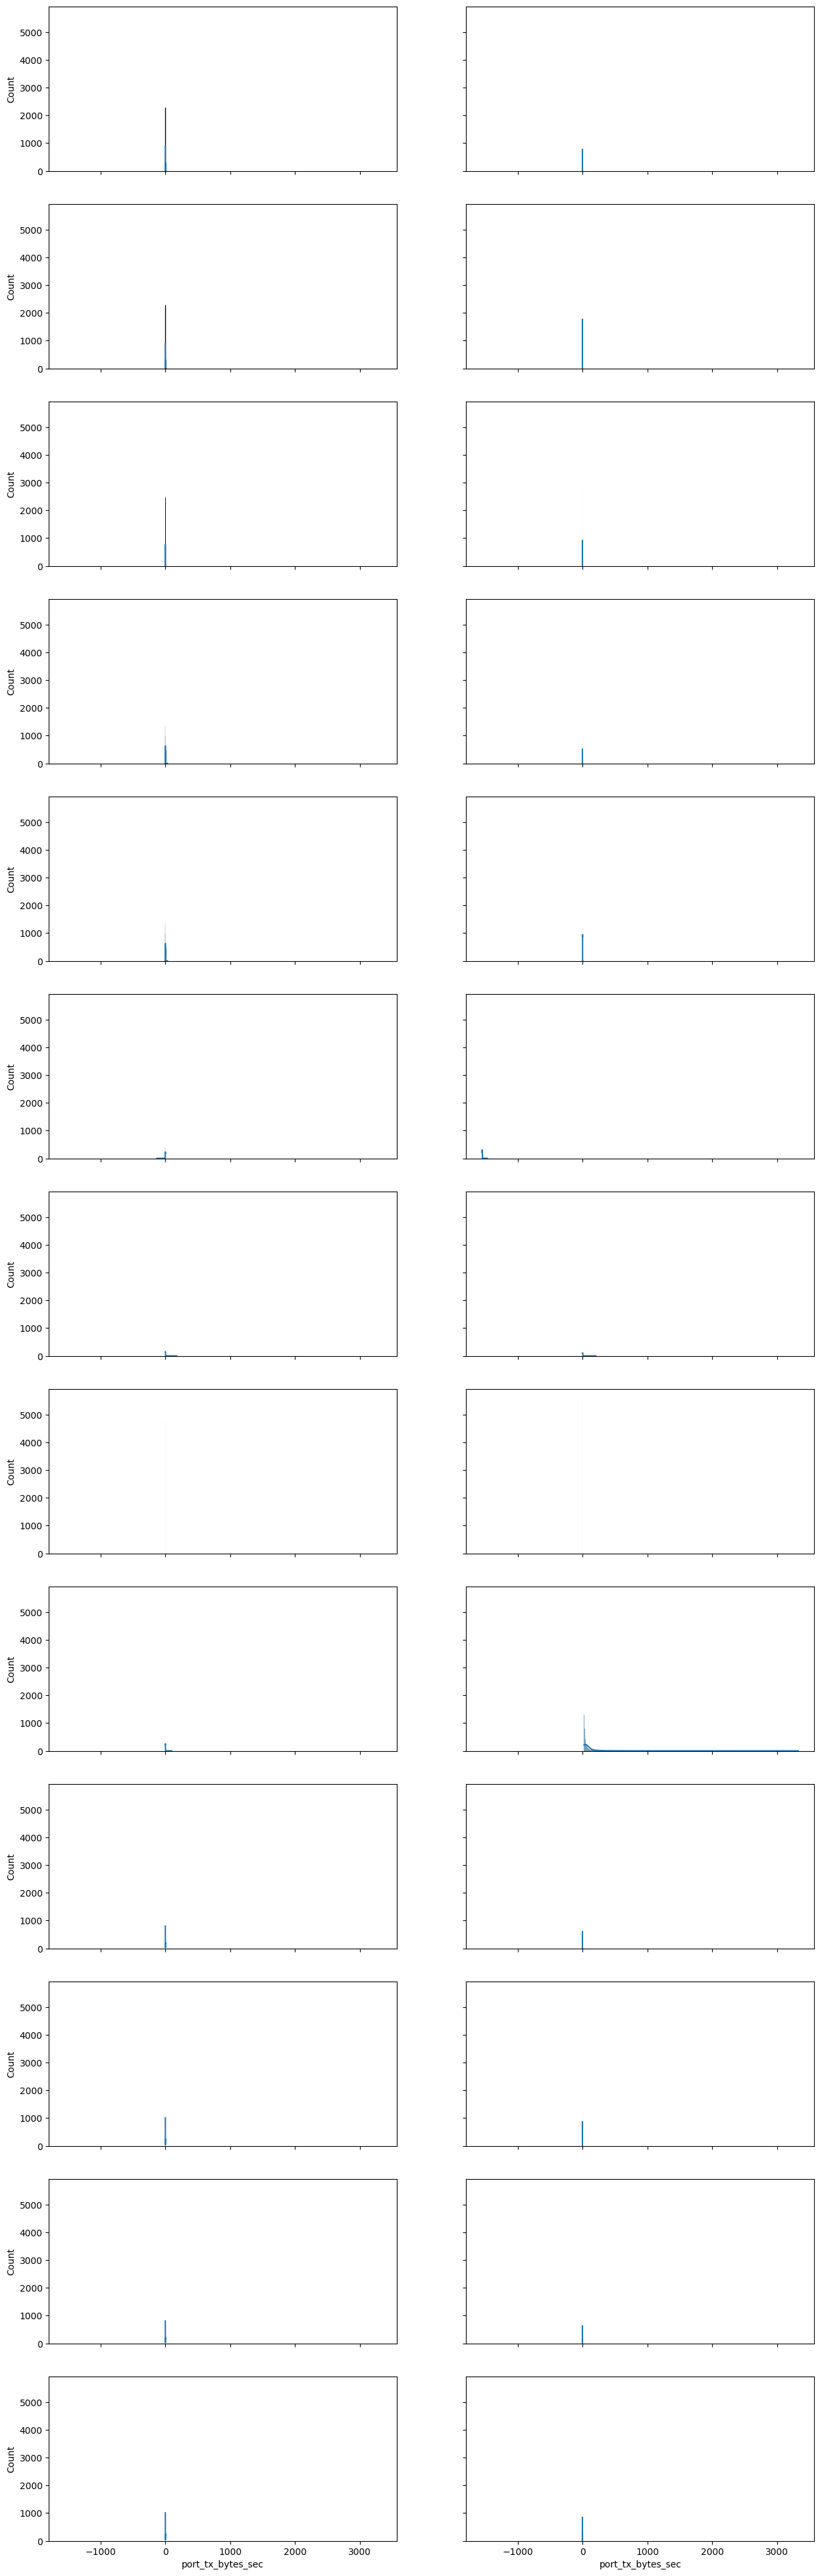

In [52]:
fig, axes = plt.subplots(len(features_list), 2, sharex=True, sharey = True, figsize=(15, 50))

i = -1
for x in features_list:
    i += 1
    sns.histplot(data=iperf, x = x, ax=axes[i, 0], kde=True)
    sns.histplot(data=w3m, x = x , ax=axes[i, 1], kde=True)